# Grab 'Em By The Posts

## Introduction:

Howdy! Welcome to our Computer Science 489 - Data Science Final Project! This year's presidential election was one of the most debated and controversial elections in the history of the United States. The United States of America has numerous news media outlets all reporting on the same event or events but with a small twist. Different News Media will reach out to different types of people when reporting the news. Some outlets will speak out to the more republican audience, some the more democratic audience, and some report in a more neutral view. So viewers are asking themselves which outlet they are wanting to listen to in the future as they start to figure out their own political view. It makes sense that predominantly republican people will want to listen to a more republican news outlet versus a more democratic news outlet.

#### Initial Questions
With all of this, we wanted to question if these news outlets are truly keeping to their bias view points or if there is significant shifts depending on specific events that occur. For example, when the email scandal with Hillary Clinton were news outlets reporting just the facts about this or were they wording to match with their desired audience. 

#### Background Motivation
Like we previously mentioned the presidential election of 2016 is historically the most debated and controversial one in the history of the US. The topic of media bias has come up several times during the campaign season. Media tends to be viewed much more during the campaign season and some news stations are known for leaning to one side or the other. A large portion of the population claim the media is biased, while another portion claims that it isn't.

#### Assumptions
For this project we sourced out to Amazon Mechanical Turk to generate some testing data for our classifier you will see down below. We did as much as we could in terms of looking for spammers just trying to make an easy buck, but may have missed a few. For cases where we found a turker trying to spam our data by simply clicking one of the 3 options for each post (positive, negative, nuetral), we simply rejected their job not paying them and did our best to fill in that missing data. Lastly, with the results data from Amazon Turk one aspect that we cannot judge just on the output is that the turkers gave us unbiased input.


## Conclusion:

In short, our analysis concludes that media bias does in fact exist. As seen in the differences between news sources over time, all media outlets have an inherent bias in their reporting but there are many conditions to this conclusion. This is because our labelling was based on human input (Amazon Turk), our classifiers were trained on bias inherently present in the population. In fact, a better statement may be: “Does media have a perceived bias?” Nonetheless, with one of the most controversial elections in the United States finally over, it is obvious that the media did not report all stories with 100% neutrality. However, everything can’t all be blamed on the media. While our graphs were very asymmetrical in the beginning because of a scarcity in data, most news outlets reported stories in a similar fashion later in the race. In fact, the most important factor in determining how a news source reports appears to be not any inherent bias, but the actions of the candidates themselves. From Clinton’s email scandal to Trump’s “grab ‘em by the p\*\*\*y”, the actual news had the most effect on the labelling of the posts. So whether you blame the candidates or the media, the only thing most of us can agree on is we’re glad this election is over.

## Getting the Data

#### How it works
When this project was first conceived, we planned on using twitter as our main source of data. Unfortunately, API restrictions prevented us from gathering tweets past a certain number, so we switched to Facebook. When gathering posts, we focused on seven main news sources: CBS, CNN, Fox, MSNBC, NYT, USA Today, and WSJ. Of these news sources, we saved every posts from April 12th to November 15th that talked about the election; specifically, any posts that used the words: 'donald', 'trump', 'hillary', 'clinton', 'electoral', 'election', or 'president-elect'. After collecting these posts, and all relevant post features, they were saved to csv’s for further analysis.

A BIG Thank You to minimaxir (GitHub) for the beautiful code with great descriptions

##### Source: https://github.com/minimaxir/facebook-page-post-scraper/blob/master/examples/how_to_build_facebook_scraper.ipynb

In [ ]:
import urllib2
import json
import datetime
import csv
import time

# !!!! APP_ID and APP_SECRET !!!!! SHOULD NOT BE POSTED TO GITHUB

#APP_ID=""
#APP_SECRET=""

ACCESS_TOKEN = APP_ID + "|" + APP_SECRET

# Here you can specify which profile to search for
#page_id = 'nytimes'

# or do what we did below and have an array of multiple profiles to search for all at once
RELEVANT_NEWS_SITES = ['usatoday','wsj','CBSNews','msnbc', 'nytimes','FoxNews','cnn']

WORDS_IN_RELEVNT_STATUSES = ['donald','trump','hillary','clinton','electoral','election','president-elect']

OLDEST_RELEVANT_DATE = [2015,4,12]
MOST_RECENT_RELEVANT_DATE = [2016,11,16]

def testFacebookPageData(page_id, access_token):
    
    # construct the URL string
    base = "https://graph.facebook.com/v2.4"
    node = "/" + page_id
    parameters = "/?access_token=%s" % access_token
    url = base + node + parameters
    
    # retrieve data
    req = urllib2.Request(url)
    response = urllib2.urlopen(req)
    data = json.loads(response.read())
    
    print json.dumps(data, indent=4, sort_keys=True)

def request_until_succeed(url):
    req = urllib2.Request(url)
    success = False
    while success is False:
        try: 
            response = urllib2.urlopen(req)
            if response.getcode() == 200:
                success = True
        except Exception, e:
            print e
            time.sleep(5)
            
            print "Error for URL %s: %s" % (url, datetime.datetime.now())

    return response.read()    


def testFacebookPageFeedData(page_id, access_token):
    
    # construct the URL string
    base = "https://graph.facebook.com/v2.4"
    node = "/" + page_id + "/feed" # changed
    parameters = "/?access_token=%s" % access_token
    url = base + node + parameters
    
    # retrieve data
    data = json.loads(request_until_succeed(url))
    
    return data
    #return json.dumps(data, indent=4, sort_keys=True)

def getFacebookPageFeedData(page_id, access_token, num_statuses):
    
    # construct the URL string
    base = "https://graph.facebook.com"
    node = "/" + page_id + "/feed" 
    parameters = "/?fields=message,link,created_time,type,name,id,likes.limit(1).summary(true),comments.limit(1).summary(true),shares&limit=%s&access_token=%s" % (num_statuses, access_token) # changed
    url = base + node + parameters
    
    # retrieve data
    data = json.loads(request_until_succeed(url))
    
    return data

def processFacebookPageFeedStatus(status):
    
    # The status is now a Python dictionary, so for top-level items,
    # we can simply call the key.
    
    # Additionally, some items may not always exist,
    # so must check for existence first
    
    status_id = status['id']
    status_message = '' if 'message' not in status.keys() else status['message'].encode('utf-8')
    link_name = '' if 'name' not in status.keys() else status['name'].encode('utf-8')
    status_type = status['type']
    status_link = '' if 'link' not in status.keys() else status['link']
    
    
    # Time needs special care since a) it's in UTC and
    # b) it's not easy to use in statistical programs.
    
    status_published = datetime.datetime.strptime(status['created_time'],'%Y-%m-%dT%H:%M:%S+0000')
    status_published = status_published + datetime.timedelta(hours=-5) # EST
    status_published = status_published.strftime('%Y-%m-%d %H:%M:%S') # best time format for spreadsheet programs
    
    # Nested items require chaining dictionary keys.
    
    num_likes = 0 if 'likes' not in status.keys() else status['likes']['summary']['total_count']
    try:
        num_comments = 0 if 'comments' not in status.keys() else status['comments']['summary']['total_count']
    except KeyError as e:
        print e
        num_comments = 0
    num_shares = 0 if 'shares' not in status.keys() else status['shares']['count']
    
    # return a tuple of all processed data
    return (status_id, status_message, link_name, status_type, status_link,
           status_published, num_likes, num_comments, num_shares)

def scrapeFacebookPageFeedStatus(page_id, access_token):
    with open('%s_facebook_statuses.csv' % page_id, 'wb') as file:
        w = csv.writer(file)
        w.writerow(["status_id", "status_message", "link_name", "status_type", "status_link",
           "status_published", "num_likes", "num_comments", "num_shares"])
        
        has_next_page = True
        num_processed = 0   # keep a count on how many we've processed
        scrape_starttime = datetime.datetime.now()
        
        print "Scraping %s Facebook Page: %s\n" % (page_id, scrape_starttime)
        
        statuses = getFacebookPageFeedData(page_id, access_token, 100)
        
        while has_next_page:
            for status in statuses['data']:

                status_data = processFacebookPageFeedStatus(status)
                date = status_data[5].split("-")
                year = int(date[0])
                month = int(date[1])
                day = int(date[2].split()[0])
                status=status_data[1]

                #print year,month,day
                #print "status:",status


                if datetime.datetime(year,month,day) < datetime.datetime(OLDEST_RELEVANT_DATE[0],OLDEST_RELEVANT_DATE[1],OLDEST_RELEVANT_DATE[2]):
                    return
                if datetime.datetime(year,month,day) < datetime.datetime(MOST_RECENT_RELEVANT_DATE[0],MOST_RECENT_RELEVANT_DATE[1],MOST_RECENT_RELEVANT_DATE[2]):
                    if any(x in status.lower() for x in WORDS_IN_RELEVNT_STATUSES):
                        w.writerow(status_data)
                else:
                    pass

                
                # output progress occasionally to make sure code is not stalling
                num_processed += 1
                if num_processed % 1000 == 0:
                    print "%s Statuses Processed: %s" % (num_processed, datetime.datetime.now())
                    
            # if there is no next page, we're done.
            if 'paging' in statuses.keys():
                statuses = json.loads(request_until_succeed(statuses['paging']['next']))
            else:
                has_next_page = False
                
        
        print "\nDone!\n%s Statuses Processed in %s" % (num_processed, datetime.datetime.now() - scrape_starttime)

'''
facebook_json = getFacebookPageFeedData(page_id, ACCESS_TOKEN,100)

file_path = "facebook_sample_data.txt"
with open(file_path, 'a') as outfile:
    json.dump(facebook_json, outfile)
    outfile.write("\n")
'''

'''
test_status = getFacebookPageFeedData(page_id, ACCESS_TOKEN, 1)["data"][0]
#print json.dumps(test_status, indent=4, sort_keys=True)

processed_test_status = processFacebookPageFeedStatus(test_status)
print processed_test_status
'''

for page_id in RELEVANT_NEWS_SITES:
    scrapeFacebookPageFeedStatus(page_id, ACCESS_TOKEN)


## This Just In: We have Confirmed that We have the Data

Awesome! Now we have data from these news media outlets with posts related to Donald Trump, Hillary Clinton, Election, President-Elect, and Electoral.

News Media Outlets:
* USA Today
* Wall Street Journal
* CBS News
* MSNBC
* New York Times
* Fox News
* CNN

Now lets take a peek at some of this data that we just grabbed and see what all we have available.


#### Reading in the Data Files

In [2]:
import pandas as pd

cbs_df = pd.read_csv('../Facebook_RAW/CBSNews_facebook_statuses.csv')
cnn_df = pd.read_csv('../Facebook_RAW/cnn_facebook_statuses.csv')
fox_df = pd.read_csv('../Facebook_RAW/FoxNews_facebook_statuses.csv')
msnbc_df = pd.read_csv('../Facebook_RAW/msnbc_facebook_statuses.csv')
nyt_df = pd.read_csv('../Facebook_RAW/nytimes_facebook_statuses.csv')
usatoday_df = pd.read_csv('../Facebook_RAW/usatoday_facebook_statuses.csv')
wsj_df = pd.read_csv('../Facebook_RAW/wsj_facebook_statuses.csv')

#### Taking a Peek

So here is a quick look at the facebook posts from CBS news station. You will notice that each row in this dataframe is an individual post. So each post will have a status_id, status_message, status_type, and many more. For this project we will be focusing on the following data per post:
* status_id - independent ID for each post
* status_message - the content or text of the post
* status_published - date and exact time the post was published to facebook

In [10]:
# taking a look at the data from CBS
cbs_df.head()

,status_id,status_message,link_name,status_type,status_link,status_published,num_likes,num_comments,num_shares
0,131459315949_10154079219290950,Management of the complex on the Upper West Si...,Three New York buildings to ditch Trump name,link,http://cbsn.ws/2f2NFK3,2016-11-15 22:18:03,625,178,102
1,131459315949_10154079127695950,Her company says they are “still making adjust...,Ivanka Trump criticized for promoting diamond ...,link,http://cbsn.ws/2fUeDRS,2016-11-15 21:33:03,399,820,187
2,131459315949_10154079007415950,"In the days following the election, the ACLU N...","ACLU, Planned Parenthood are receiving ""unprec...",video,https://www.facebook.com/CBSNews/videos/101540...,2016-11-15 20:37:47,494,151,114
3,131459315949_10154078949670950,"In this city, someone spray painted ""black liv...",More than 200 hate crimes reported since the e...,link,http://cbsn.ws/2fTvJz9,2016-11-15 20:01:06,269,391,427
4,131459315949_10154078822465950,The latest on the Trump transition team:\n- Tr...,LIVE BLOG: Trump transition to the White House,link,http://cbsn.ws/2fTYJHl,2016-11-15 19:01:02,171,322,85


### ANALYSIS OF RAW DATA

After grabbing all 22,000 posts from Facebook we wanted to quickly observe it by looking at a few different things. After seeing that 55% of our posts were about Trump we then wondered how much each news outlet talked about Trump, Clinton, or other. So in the graph “Number of Posts per News Outlet” you can clearly see that Trump is most talked about between the 3 categories across all news outlets that we gathered data from. To distinguish what posts fell into each category we followed the following guidelines. If the post mentions only about Trump, it is a Trump post. If the post mentions only about Clinton, it is a Clinton post. If the post mentions both Trump and Clinton, or mentions anything related to our subject (election, president, etc.) it is classified as an Other post. Lastly, looking at the raw data we wanted to observe the distribution of posts between the news outlets and the two categories Trump and Clinton. The only thing that is observable is we have relatively equal ratio of posts for each outlet in both categories.

##### Examine below the charts covering our raw data. (graphs are interactive! "OOOOOO....AAAAAHHH")

In [7]:
from IPython.core.display import display, HTML
display(HTML('<!DOCTYPE html><html><head><h1></h1><br></head><body><figure><embed type="image/svg+xml" src="../Data Viz/total_posts_pie.svg" /></figure></body></html>'))

In [6]:
display(HTML('<!DOCTYPE html><html><head><h1></h1><br></head><body><figure><embed type="image/svg+xml" src="../Data Viz/total_posts_per_source.svg" /></figure></body></html>'))

In [8]:
display(HTML('<!DOCTYPE html><html><head><h1></h1><br></head><body><figure><embed type="image/svg+xml" src="../Data Viz/post_distribution_trump.svg" /></figure></body></html>'))

In [9]:
display(HTML('<!DOCTYPE html><html><head><h1></h1><br></head><body><figure><embed type="image/svg+xml" src="../Data Viz/post_distribution_clinton.svg" /></figure></body></html>'))

## Cleaning the Data

Here we have just some simple scripts to clean the data. More specifically the actual message within the post. First, we removed newline characters and then any hyperlinks that were embedded in the post becuase these do not factor in the text analysis. Lastly, we had to remove rows that had NaN in the status_message column. There were certain cases where after performing the previous lines to clean the data corrupted the actual content and converted it to a NaN object.

In [ ]:
# you can check for any null data in each column
# you can replace the df here to check for all
msnbc_df.isnull().any()

# removing \n characters
cbs_df['status_message'] = cbs_df['status_message'].apply(lambda x: x.replace("\n", ""))
cnn_df['status_message'] = cnn_df['status_message'].apply(lambda x: x.replace("\n", ""))
fox_df['status_message'] = fox_df['status_message'].apply(lambda x: x.replace("\n", ""))
msnbc_df['status_message'] = msnbc_df['status_message'].apply(lambda x: x.replace("\n", ""))
nyt_df['status_message'] = nyt_df['status_message'].apply(lambda x: x.replace("\n", ""))
usatoday_df['status_message'] = usatoday_df['status_message'].apply(lambda x: x.replace("\n", ""))
wsj_df['status_message'] = wsj_df['status_message'].apply(lambda x: x.replace("\n", ""))

# removing hyperlinks within text
cbs_df['status_message'] = cbs_df['status_message'].apply(lambda x: re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}     /)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', x))
cnn_df['status_message'] = cnn_df['status_message'].apply(lambda x: re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}     /)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', x))
fox_df['status_message'] = fox_df['status_message'].apply(lambda x: re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}     /)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', x))
msnbc_df['status_message'] = msnbc_df['status_message'].apply(lambda x: re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}     /)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', x))
nyt_df['status_message'] = nyt_df['status_message'].apply(lambda x: re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}     /)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', x))
usatoday_df['status_message'] = usatoday_df['status_message'].apply(lambda x: re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}     /)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', x))
wsj_df['status_message'] = wsj_df['status_message'].apply(lambda x: re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}     /)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', x))


# After running the above lines we ran into cases where we had a few status_messages 
# removing rows of data where 'status_message' is NaN
cbs_df = cbs_df.dropna(subset=['status_message'])
cnn_df = cnn_df.dropna(subset=['status_message'])
fox_df = fox_df.dropna(subset=['status_message'])
msnbc_df = msnbc_df.dropna(subset=['status_message'])
nyt_df = nyt_df.dropna(subset=['status_message'])
usatoday_df = usatoday_df.dropna(subset=['status_message'])
wsj_df = wsj_df.dropna(subset=['status_message'])

## Amazon Turk

Since we are grabbing data straight off of facebook we do not have any pre-determined labels for these posts. So we do not know what is considered positive, negative, or nuetral. So we have to resource out to Amazon Turk Services to produce a testing set for our text analysis algorithm. The code belows shows how we chose data from our original set of data.

To create our input data for turk we simply grabbed 250 samples from each news outlet and created a dataframe and outputted that into a csv file. Then we simply placed that on Amazon Turk and waited a couple of days for our training data to come in. Here is an example of 250 randomly selected posts from CBS.

In [3]:
cbs_turk = pd.read_csv('../Turk/cbs_input.csv')
cbs_turk.head()

,Unnamed: 0,statis_id,content,source
0,406,131459315949_10154051614130950,How did Trump react when a fan gave him a mask...,cbs
1,720,131459315949_10153990938455950,"""I'd advise Mr. Trump to stop whining,” said O...",cbs
2,2028,131459315949_10153440716410950,Both Hillary Clinton and Bernie Sanders had am...,cbs
3,2653,131459315949_10153106725885950,"This morning's headlines from CBS News, includ...",cbs
4,1543,131459315949_10153736754135950,JUST IN: Donald J. Trump to name Indiana Gover...,cbs


### Results from Amazon Turk

Because of the nature of what was studied, opinions about labels varied significantly. As shown in the pie chart, only 39.6% of turkers had a uniform consensus on the bias of a post, and only 53.93% of labeled posts 2 out of the 3 turkers agreed. Getting turkers to label our posts with an unbiased opinion is a hard task to judge when analyzing our testing data. We had few turkers that labeled over 100 posts. To ensure that the labels are all unbiased is too difficult to determine by just looking at the output. We were however able to deny turkers that tried to spam our dataset by clicking one of the label options for every post presented to them.

In [17]:
display(HTML('<!DOCTYPE html><html><head><h3></h3><br></head><body><figure><embed type="image/svg+xml" src="../Data Viz/turk_agreement_pie.svg" /></figure></body></html>'))

# The Classification to label data

In [1]:
import os            # Get current working directory to locate Turk files
import pandas as pd  # Pandas to store and manipulate data
from datetime import datetime # to import date info for posts
import time
from textblob import TextBlob
import re
from nltk.corpus import stopwords # Import the stop word list
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
import math

In [2]:
# Import the labeled data
sample = pd.read_csv(os.getcwd() + "/../Turk/6source_results_filtered.csv")
print sample.head()

         WorkerId                 Input.statis_id  \
0  A2XFO0X6RCS98M    5550296508_10155606385896509   
1  A3CPL5WWI6KWLF    5550296508_10155606385896509   
2  A177EXELDLWTWV    5550296508_10155606385896509   
3  A3ECQH01KJNQ63  131459315949_10153427911075950   
4  A314XJY8V1YL12  131459315949_10153427911075950   

                                       Input.content Input.source  \
0  It is unusual for a president's children to be...          cnn   
1  It is unusual for a president's children to be...          cnn   
2  It is unusual for a president's children to be...          cnn   
3  Just hours after Mitt Romney blasted Donald J....          cbs   
4  Just hours after Mitt Romney blasted Donald J....          cbs   

  Answer.sentiment  
0         Negative  
1         Positive  
2         Positive  
3         Negative  
4         Negative  


In [3]:
# Each post has three answers. Combine them into one (pos/neu/neg)
# If a post has two or more same answers, then we will follow the answer
# If a post has all different answer, then we will throw it away

new_index = range(0, len(sample.index)/3)
new_sample = pd.DataFrame(index=new_index, columns=['texts', 'sources', 'labels', 'statusID'])

text = ""     # Keeping the text of the post we are working on
source = ""   # Keeping the source of the post we are working on
statusID = "" # Keeping the status ID of the post we are working on

num_pos = 0   # number of 'positive' answers of the post we are working on
num_neu = 0   # number of 'neutral' answers of the post we are working on
num_neg = 0   # number of 'negative' answers of the post we are working on
pd_index = 0  # Index for the post we are working on to be placed in new_sample

for index, row in sample.iterrows():
    # If this new post is different post, then append what we worked so far
    if text != row['Input.content']:
        if text != "":
            if num_pos >= 2:
                new_sample.loc[[pd_index], ['labels']] = 1
            elif num_neu >= 2: # could be commented out for pos/neg
                new_sample.loc[[pd_index], ['labels']] = 0
            elif num_neg >= 2:
                new_sample.loc[[pd_index], ['labels']] = -1
            else: # 1:1:1
                pd_index -= 1 # to keep the same index

            new_sample.loc[[pd_index], ['sources']] = source
            new_sample.loc[[pd_index], ['texts']] = text
            new_sample.loc[[pd_index], ['statusID']] = statusID
            pd_index += 1
            
        # Assign a new post
        text = row['Input.content']
        source = row['Input.source']
        statusID = row['Input.statis_id']
        num_pos = 0
        num_neu = 0
        num_neg = 0
        
    if row['Answer.sentiment'] == "Positive":
        num_pos += 1
    elif row['Answer.sentiment'] == "Neutral":
        num_neu += 1
    elif row['Answer.sentiment'] == "Negative":
        num_neg += 1

# may not be perfect, so delete not assigned rows
new_sample = new_sample.dropna()
        
new_sample['labels'] = new_sample['labels'].astype('int')
    
print sample.shape
print new_sample.shape # This should have 1/3 number of rows than "sample"

sample = new_sample
print sample.head()

(4500, 5)
(1402, 4)
                                               texts   sources  labels  \
0  It is unusual for a president's children to be...       cnn       1   
1  Just hours after Mitt Romney blasted Donald J....       cbs      -1   
2  Hillary Clinton wins the state of Washington, ...       cbs       1   
3  "We have to take the jobs away from other coun...       fox      -1   
4  Jessica Leeds, 74, of Manhattan, was one of tw...  usatoday      -1   

                         statusID  
0    5550296508_10155606385896509  
1  131459315949_10153427911075950  
2  131459315949_10154056641215950  
3   15704546335_10153385284896336  
4   13652355666_10153933280450667  


#### Side Notes:
We thought about calculating the averages of labels like two positives (1.0 x 2) and one negative (0.0 x 1) will give us 0.666 score or one positive (1.0 x 1) and two negatives (-1.0 x 2) will give us -0.333. <br>
But after computing the classification, it performed much worse, so we are sticking with our original idea to throw away the answer that the turker was not so likely paying attention, etc.

In [4]:
# Lemmanize words (e.g. is, are, am ->> be)
# Might be better to skip it

new_index = range(0, len(sample.index))
new_sample = pd.DataFrame(index=new_index, columns=("texts", "sources", "labels"))

for index, row in sample.iterrows():
    text = re.sub(r'\W+' , ' ', row['texts']) # Getting rid of punctuation
    blob = TextBlob(text)
    newtexts = ""

    for sentence in blob.sentences:
        newtext = ""

        for word in sentence.words:
            newtext += " " + word.lemmatize('v') # 'v' for 'verb'

        newtexts += newtext
    new_sample['texts'].loc[index] = newtexts
    
sample['texts'] = new_sample['texts']
print sample.head()

                                               texts   sources  labels  \
0   It be unusual for a president s children to b...       cnn       1   
1   Just hours after Mitt Romney blast Donald J T...       cbs      -1   
2   Hillary Clinton win the state of Washington C...       cbs       1   
3   We have to take the job away from other count...       fox      -1   
4   Jessica Leeds 74 of Manhattan be one of two w...  usatoday      -1   

                         statusID  
0    5550296508_10155606385896509  
1  131459315949_10153427911075950  
2  131459315949_10154056641215950  
3   15704546335_10153385284896336  
4   13652355666_10153933280450667  


In [5]:
# Getting rid of too common words (e.g. the, an)

new_index = range(0, len(sample.index))
new_sample = pd.DataFrame(index=new_index, columns=("texts", "sources", "labels"))

for index, row in sample.iterrows():
    # If this new post is different post, then append what we worked so far
    words = [w for w in row['texts'].split() if not w in stopwords.words("english")]
    new_sample['texts'].loc[index] = ' '.join(words)

sample['texts'] = new_sample['texts']
print sample.head()

                                               texts   sources  labels  \
0  It unusual president children clue White House...       cnn       1   
1  Just hours Mitt Romney blast Donald J Trump sp...       cbs      -1   
2  Hillary Clinton win state Washington CBS News ...       cbs       1   
3  We take job away countries make product take m...       fox      -1   
4  Jessica Leeds 74 Manhattan one two women quote...  usatoday      -1   

                         statusID  
0    5550296508_10155606385896509  
1  131459315949_10153427911075950  
2  131459315949_10154056641215950  
3   15704546335_10153385284896336  
4   13652355666_10153933280450667  


#### Side Notes:

For machine learning, not a sentiment analysis, we also used candidate information (whether a post was talking about either candidate or both) or timestamp (published year, month, hour of the post), but neither of them were that helpful.

### For classification from Scikit Learn, we were trying various classification methods such as

- Naive Bayes (MultinomialNB, GaussianNB, BernoulliNB)
- Linear models (LogisticRegression, LogisticRegressionCV, SGDClassifier, Ridge, RidgeClassifier, RidgeClassifierCV, ElasticNet, LassoLars, PassiveAggressiveClassifier)
- SVM (SVC, LinearSVC)
- Neighboring methods (KNeighborsClassifier, NearestCentroid)
- Ensemble (GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier)
- Tree methods (ExtraTreeClassifier, DecisionTreeClassifier)

With two feature extraction methods (CountVectorizer, TfidfVectorizer)<br>
while tweaking 
- min_df from 0.01 to 0.20
- max_df from 0.70 to 1.00

But we didn't get any scoring better than 0.6 <br>
-> That made us shift our direction to NLTK

In [6]:
# Using Naive Bayes Classifier in NLTK 

def word_feats(words):
    return dict([(word, True) for word in words])

# We got a better score when we only considered pos/neg without neutral,
# so we commented them off.

# This one grabs texts from the labeled dataframe "sample"
#     for an argument when labels match to either 1 (posfeats) or -1 (negfeats).
# Then the function returns the array of dictionary [word:True] for each 
negfeats = [(word_feats(text.split()), 'neg') for text in sample.loc[sample['labels'] == -1]['texts']]
posfeats = [(word_feats(text.split()), 'pos') for text in sample.loc[sample['labels'] == 1]['texts']]
#neufeats = [(word_feats(text.split()), 'neu') for text in sample.loc[sample['labels'] == 0]['texts']]

# Cutting off at 92% line. Since we have small labeled set,
# we decided that having bigger training set would be better
negcutoff = int(math.ceil(len(negfeats)*0.92)) # 92%
poscutoff = int(math.ceil(len(posfeats)*0.92)) # 92%
#neucutoff = int(math.ceil(len(neufeats)*0.92)) # 92%
 
trainfeats = negfeats[:negcutoff] + posfeats[:poscutoff] #+ neufeats[:neucutoff]
testfeats = negfeats[negcutoff:] + posfeats[poscutoff:] #+ neufeats[neucutoff:]
print 'train on %d instances, test on %d instances' % (len(trainfeats), len(testfeats))
 
classifier = NaiveBayesClassifier.train(trainfeats)
print 'accuracy:', nltk.classify.util.accuracy(classifier, testfeats)
classifier.show_most_informative_features()

train on 665 instances, test on 56 instances
accuracy: 0.767857142857
Most Informative Features
                Carolina = True              pos : neg    =     11.9 : 1.0
                 project = True              pos : neg    =      9.1 : 1.0
                     NBC = True              pos : neg    =      8.7 : 1.0
                    love = True              pos : neg    =      8.7 : 1.0
                  attack = True              neg : pos    =      8.5 : 1.0
                 history = True              pos : neg    =      7.2 : 1.0
               community = True              pos : neg    =      7.2 : 1.0
                    beat = True              pos : neg    =      7.2 : 1.0
                   Kaine = True              pos : neg    =      7.2 : 1.0
                       7 = True              pos : neg    =      7.2 : 1.0


### After struggling to get a score of 0.6, we decided that 0.75 or above is a good score for us to go ahead. So we will be labeling the rest of raw data with this trained machine.

In [7]:
# Reading the data in
raw = {}
raw['cbs'] = pd.read_csv(os.getcwd() + '/../Facebook_RAW/CBSNews_facebook_statuses.csv')
raw['cnn'] = pd.read_csv(os.getcwd() + '/../Facebook_RAW/cnn_facebook_statuses.csv')
raw['fox'] = pd.read_csv(os.getcwd() + '/../Facebook_RAW/FoxNews_facebook_statuses.csv')
raw['msnbc'] = pd.read_csv(os.getcwd() + '/../Facebook_RAW/msnbc_facebook_statuses.csv') 
raw['nyt'] = pd.read_csv(os.getcwd() + '/../Facebook_RAW/nytimes_facebook_statuses.csv') 
raw['usatoday'] = pd.read_csv(os.getcwd() + '/../Facebook_RAW/usatoday_facebook_statuses.csv')
raw['wsj'] = pd.read_csv(os.getcwd() + '/../Facebook_RAW/wsj_facebook_statuses.csv')

print raw['cbs'].head()

                        status_id  \
0  131459315949_10154079219290950   
1  131459315949_10154079127695950   
2  131459315949_10154079007415950   
3  131459315949_10154078949670950   
4  131459315949_10154078822465950   

                                      status_message  \
0  Management of the complex on the Upper West Si...   
1  Her company says they are “still making adjust...   
2  In the days following the election, the ACLU N...   
3  In this city, someone spray painted "black liv...   
4  The latest on the Trump transition team:\n- Tr...   

                                           link_name status_type  \
0       Three New York buildings to ditch Trump name        link   
1  Ivanka Trump criticized for promoting diamond ...        link   
2  ACLU, Planned Parenthood are receiving "unprec...       video   
3  More than 200 hate crimes reported since the e...        link   
4     LIVE BLOG: Trump transition to the White House        link   

                               

In [8]:
machine_labeled = {}

# Creating empty dataframes
for key, value in raw.iteritems(): # key: 'cbs', 'cnn', etc.
    machine_labeled[key] = pd.DataFrame(columns=("texts", "labels"), 
                                       index = raw[key].index)

for key, value in raw.iteritems(): # for each media
    for index, row in raw[key].iterrows(): # iterate through rows per media

        text = raw[key]['status_message'][index]
        
        # word_feats() was used to create train/test sets. 
        # Changing the text in the same format to classify
        wfsp = word_feats(text.split())
        
        guessed_label = classifier.classify(wfsp)
        
        machine_labeled[key]['texts'][index] = text
        machine_labeled[key]['labels'][index] = guessed_label

    print key + "      \t" + "%d\t%d" % \
    (machine_labeled[key]['labels'].str.count("neg").sum(),
     machine_labeled[key]['labels'].str.count("pos").sum())

usatoday      	1186	576
wsj      	1434	1105
fox      	2760	1219
nyt      	2306	900
cbs      	1711	1079
cnn      	2344	1342
msnbc      	2729	1358


In [9]:
# Writing to CSV files
for key, value in machine_labeled.iteritems(): # for each media
    machine_labeled[key].to_csv("../Machine_labeled_Haru/machine_labeled_"+key+".csv")

### Why did we only show one classifier if we used two?

Our original classifier began by trying to predict a posts label out of three values: positive, neutral, and negative. But no matter what was done, the accuracy never rose above 55%. In order to combat this, we moved to a classifier that focused on predicting just two different labels: positive and negative (which is the code above). This gives us a a better accuracy of 76.7%.

Though if you were to place these two different classified labels on timelines (see below) they both tell you differnt things. The classifier that uses nuetral as an label option tells you what outlets are leaning towards one candidate over the other. Whereas classifer that uses just positive and negative labels, allows you to see when certain events might have occurred.

In [18]:
display(HTML('<!DOCTYPE html><html><head><h3>Timeline graph using pos/neg/nue labels</h3><br></head><body><figure><embed type="image/svg+xml" src="../Data Viz/timeline_pos_neu_neg_clinton.svg" /></figure></body></html>'))

In [19]:
display(HTML('<!DOCTYPE html><html><head><h3>Timeline graph using pos/neg/nue labels</h3><br></head><body><figure><embed type="image/svg+xml" src="../Data Viz/timeline_pos_neu_neg_trump.svg" /></figure></body></html>'))

In [16]:
display(HTML('<!DOCTYPE html><html><head><h3>Timeline graph using pos/neg labels</h3><br></head><body><figure><embed type="image/svg+xml" src="../Data Viz/timeline_neg_clinton.svg" /></figure></body></html>'))

In [15]:
display(HTML('<!DOCTYPE html><html><head><h3>Timeline graph using pos/neg labels</h3><br></head><body><figure><embed type="image/svg+xml" src="../Data Viz/timeline_neg_trump.svg" /></figure></body></html>'))

### Timeline Notes:
Observing both timeline charts, “% of Negative Posts about Trump/Clinton”, it's evident the data points are sporadic throughout the first six to seven months. On the latter half of the timeline, it shows that the news outlets are generally posting in the same direction (negative vs positive) but with a slight difference in the degree. This is likely happening because more than 10 candidates for both the Republican and Democratic party at the start of the campaign season, and in the latter half, candidates started to drop out. So in the last few months, the posts are typically about Trump or Clinton because of their high probability to win the Republican and Democratic nomination respectively. Since there are more posts about them in the latter half of the timeline, a better turnout of posts fall in the positive or negative category over time.

These charts point out a time frame to dig deeper into the data set and discover why there was a sudden shift from relatively positive posts to negative posts and vice versa. For example, in the Clinton timeline, we are able to see that from June to July 2016, she is receiving more positive posts than before. However, from August to October 2016, some event occurred that resulted in the media reporting in a more negative tone. Trump’s ratings improved after the Republican National Convention and received more positive votes than the previous month.

## More Analysis (Taking a dive into our timeline)

With the above two timelines we can pinpoint a month and find out what is going on during that time frame to discover more in details.

We will examine in details the following time frames:
* October 7, 2016 - October 14, 2016 (Trump)
* September 1, 2016 - September 13, 2016 (Clinton)
* July 24, 2016 - July 29, 2016 (Democratic National Convention)
* July 17, 2016 - July 22, 2016 (Democratic National Convention)

#### "Grab Em by the P\*\*\*y" Trump Scandal

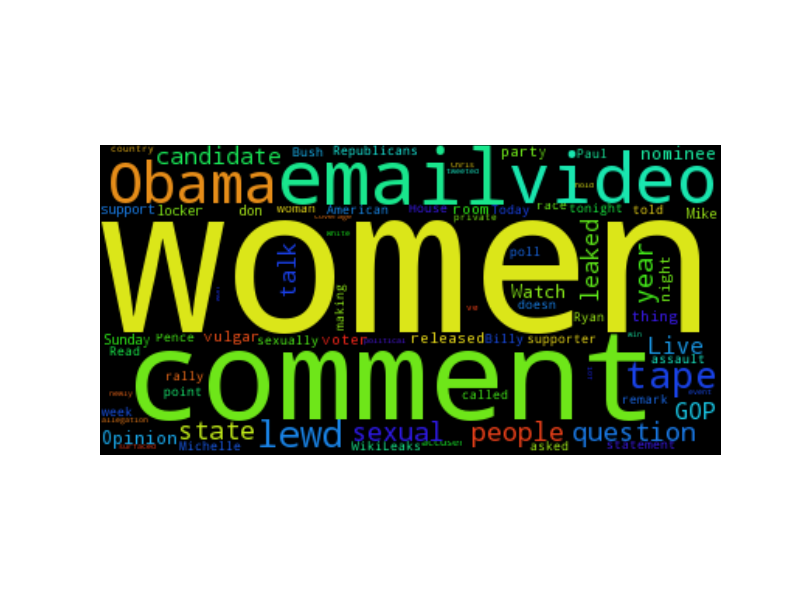

In [22]:
display(HTML('<!DOCTYPE html><html><head><h3>WordCloud</h3></html>'))
from IPython.display import Image
Image("../Data Viz/Wordcloud/wordcloud_grabem_both_10-07_10-14.png")

In [24]:
display(HTML('<!DOCTYPE html><html><head><h3>Timeline graph for Trump Scandal</h3><br></head><body><figure><embed type="image/svg+xml" src="../Data Viz/wordcloud_grab_timeline_pos.svg" /></figure></body></html>'))

##### Notes:
During Donald Trump’s “grab ‘em by the p\*\*\*y” scandal, issues about women's rights became extremely relevant, and it shows in the way the media reported it. With most frequent words, ‘women’, ‘lewd’, ‘sexual’, and ‘tape’, the media focused heavily on the scandal at hand. The only difference between this controversy and the Hillary Clinton’s emails was that in Trump’s case, all media outlets reported negatively towards him.

#### Clinton Email Scandal

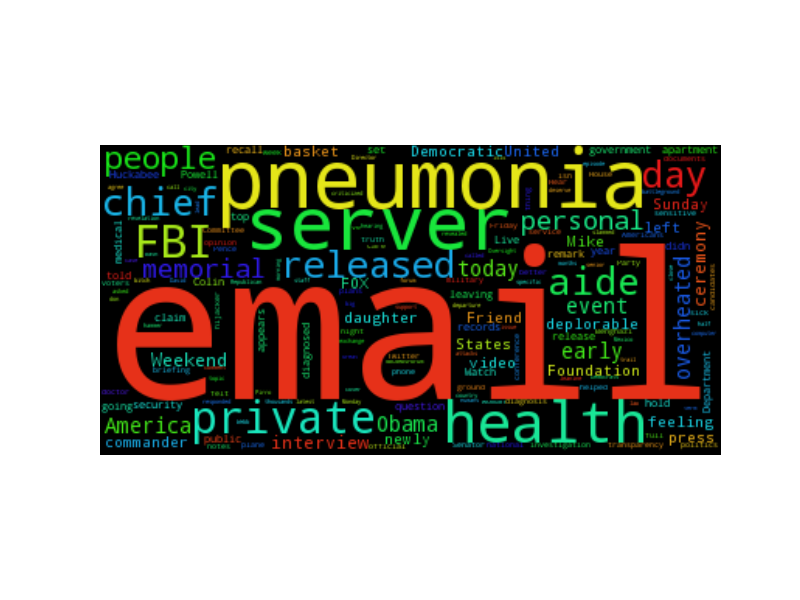

In [27]:
display(HTML('<!DOCTYPE html><html><head><h3>WordCloud</h3></html>'))
Image("../Data Viz/Wordcloud/wordcloud_01_email_clinton_09-01_09-13.png")

In [28]:
display(HTML('<!DOCTYPE html><html><head><h3>Timeline graph for Clinton Scandal</h3><br></head><body><figure><embed type="image/svg+xml" src="../Data Viz/wordcloud_email_timeline_pos.svg" /></figure></body></html>'))

##### Notes:
Hillary Clinton’s email scandal was undoubtedly one of the most talked about events of the election and it shows in the way it was reported by the media. Observing the wordcloud you will notice the most occurring subjects during this time frame (Sept. 1 - 13) were ‘email’, ‘FBI’, ‘server’, and ‘pneumonia’. While one may assume all news sources would report negatively about Clinton during this time, a completely different story unfolded. Some coverage took a sharp decline, while other news outlets had an increase in positive posts, revealing a potential compromise for the sudden leak of bad news. The only certainty is that the email scandal served to separate the reporting bias of the news outlets instead of uniting them behind a specific case.

#### Republican and Democratic Conventions Wordcloud

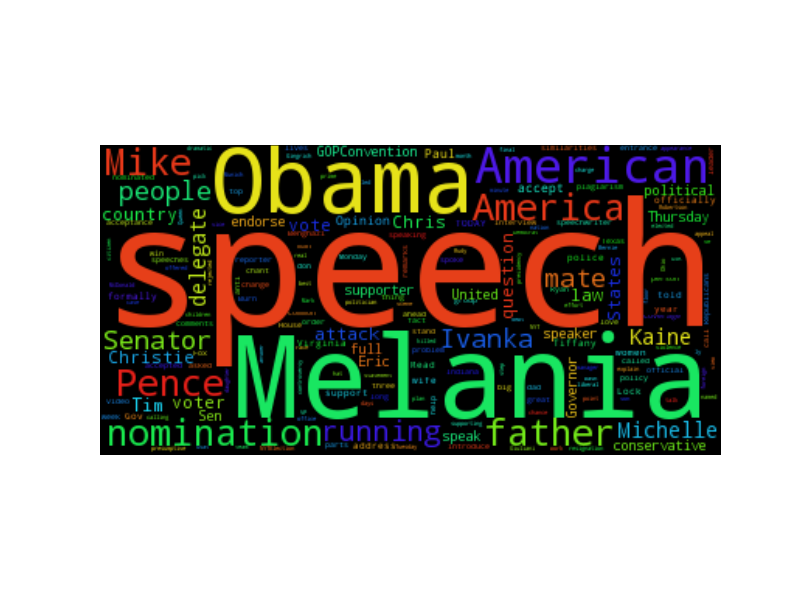

In [33]:
display(HTML('<!DOCTYPE html><html><head><h3>RNC Wordcloud</h3></html>'))
Image("../Data Viz/Wordcloud/wordcloud_rnc_both_07-17_07-22.png")

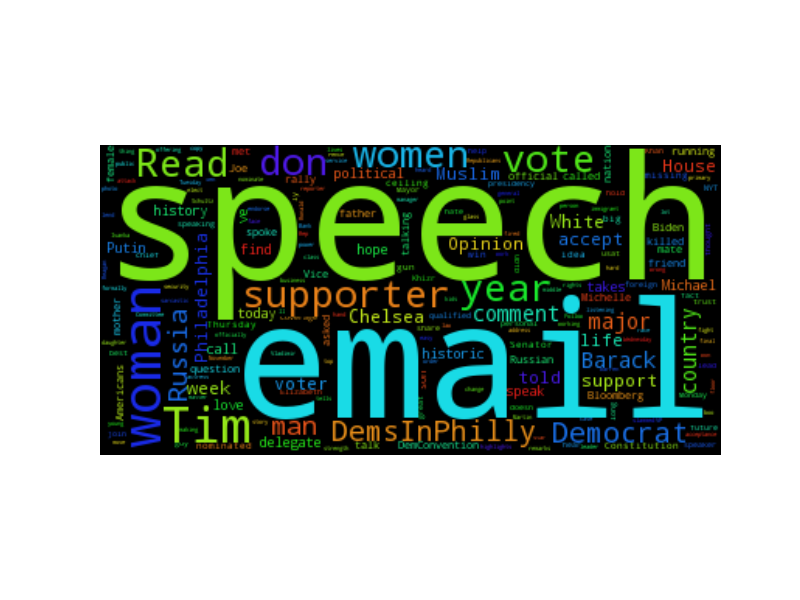

In [34]:
display(HTML('<!DOCTYPE html><html><head><h3>DNC Wordcloud</h3></html>'))
Image("../Data Viz/Wordcloud/wordcloud_dnc_both_07-24_07-29.png")

##### Notes:
The word clouds from the DNC and RNC do a good job of showing the trending issues at the time. For the RNC, controversy arose over Melania Trump’s speech. The three most frequent words are ‘Melania’, ‘Obama’, and ‘speech’; all of which relate to the accusal of Melania Trump stealing Michelle Obama’s speech. During the DNC, the word cloud seems to suggest that Clinton spent a majority of the time defending her email scandal. The speech word prevalence might be a side effect of the event or carried over from the RNC controversy.

## Takeaways and Considerations

We learned many cool things during the process of this project. We learned how Facebook API is more relaxed than Twitter API when trying to scrape the amount of data that was needed for this project. We went through the long hours of reviewing turker output to make sure we did not have spammers, and learned incredibly fast that it is impossible to judge if a turker is being biased or unbiased. Trying to find the correct Classifier to be able to produce labels for out posts was another hill that took us a while to get over.

Things that we would suggest to anyone that tries to recreate this project is to try and use something other than Amazon Turk to get your initial labels for training data. We believe that the turker results may have affected our classifier and its performance in accuracy. 

### Presentation

Please enjoy these other presentation methods that we have created, as well as a link to our github to view all of the code:

* [Video](https://www.youtube.com/)
* [Website](http://people.tamu.edu/~ccardin9/)
* [Github](https://github.tamu.edu/jarheadr176/489Project)